<img src="GCD_logo.png" align="right" style="float" width="50">
<font color="#CA3532"><h1 align="left">Proyecto Final PLN</h1></font>
<font color="#6E6E6E"><h2 align="left">Clasificador de las noticias de portada de meneame.net</h2></font> 


<a id="5"></a><h1 style='background:#26A2AB; border:1; color:white'><center>Guillem Miralles</center></h1>

### ÍNDICE:
0. Librerias
1. Lectura y Análisis exploratorio
2. División de clases
3. Normalización
4. Lectura y Post-preprocesing
5. Vectores Sparse
6. Balanceo de clases
7. Modelado Topic Modeling (LSA)
8. Modelado con Doc2Bow
9. Modelado con Keras
10. Mejora de los modelos
11. Conjunto test
12. Conclusión

### 0. Librerias:

In [1]:
# Básicos
import pandas as pd
import numpy as np


# Plots
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

# Extracción de características
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# PLN
import os, re, string, spacy

# Barra progreso
from tqdm import tqdm

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.svm import LinearSVC


# Balanceo
import imblearn
from imblearn.over_sampling import SMOTE

#Méticas
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Keras:
import itertools

%matplotlib inline
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

#LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Otros
import warnings
from gensim.models import Doc2Vec

import gensim
from gensim.models.doc2vec import TaggedDocument
import re

C:\Users\guill\Anacona\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 1. Lectura y Análisis exploratorio

Vamos a leer los datos. Este conjunto de datos disponible en http://oceano.uv.es/SB/meneame.csv.zip y incluye la información de las noticias que aparecen en la portada de la web www.meneame.net. Los datos van desde Diciembre de 2005 hasta el 4 de diciembre de 2017. Hay 177.000 observaciones con 17 variables: noticias, usuarios, hora de envío, votos negativos, votos positivos, descripción, etc. La mayor parte de las noticias están en español. La clase a predecir es el tipo de noticia (columna SUB de la base de datos), a partir de las columnas de NOTICIA y EXTRACTO. Vamos a realizar la lectura.

In [12]:
warnings.filterwarnings("ignore")

df = pd.read_csv('data/data.csv',sep=';')
df.head()

,index,noticia,link_noticia,web,usuario,id_usuario,fecha_envio,fecha_publicacion,meneos,clicks,comentarios,votos_positivos,votos_anonimos,votos_negativos,karma,sub,extracto
0,2869055,Ruptura inesperada de un iceberg gigante desp...,https://www.bas.ac.uk/media-post/giant-west-an...,bas.ac.uk,jm22381,21061,1512164817,1512382803,73,1057,10,55,18,2,340,cultura,Una animación del iceberg gigante que nació de...
1,2869761,"El MIT logra hacer escáneres 3D baratos 1,000...",https://gizmodo.com/mit-figured-out-how-to-mak...,gizmodo.com,CalzadorCalzado,553023,1512352183,1512381302,73,772,17,43,30,1,331,tecnología,Los científicos ya desarrollaron una tecnologí...
2,2869841,"“Lárgame un cilindrín, fotero”",http://www.teknoplof.com/2017/12/04/largame-un...,teknoplof.com,gobolino,511338,1512377483,1512379520,89,1608,34,53,36,5,396,ocio,"‘La gran superproducción‘ es, sin ningún géner..."
3,2869859,El Tribunal Supremo deja en prisión a Junquer...,http://www.eldiario.es/politica/Tribunal-Supre...,eldiario.es,Raditz,382296,1512378799,1512379503,171,889,90,98,73,1,452,actualidad,El juez Llarena acuerda libertad previo pago d...
4,2869823,La Fiscalía pide imputar a Aguirre y Gallardó...,http://www.elboletin.com/noticia/156624/nacion...,elboletin.com,Danichaguito,407263,1512375033,1512379203,354,353,39,144,210,0,324,actualidad,La Fiscalía en el caso Lezo ha solicitado impu...


Veamos que tipo de variables tenemos en nuestro dataframe:

In [13]:
df.dtypes

index                 int64
noticia              object
link_noticia         object
web                  object
usuario              object
id_usuario            int64
fecha_envio           int64
fecha_publicacion     int64
meneos                int64
clicks               object
comentarios          object
votos_positivos       int64
votos_anonimos        int64
votos_negativos       int64
karma                 int64
sub                  object
extracto             object
dtype: object

In [14]:
df.describe()

,index,id_usuario,fecha_envio,fecha_publicacion,meneos,votos_positivos,votos_anonimos,votos_negativos,karma
count,1.775090e+05,177509.000000,1.775090e+05,1.775090e+05,177509.000000,177509.000000,177509.000000,177509.000000,177509.000000
mean,1.297267e+06,143099.818257,1.309050e+09,1.309076e+09,585.399343,239.303568,346.095775,3.755410,589.655708
std,8.865680e+05,142039.798847,1.016085e+08,1.016080e+08,448.844704,124.185722,337.832602,7.831172,147.497924
min,1.000000e+00,1.000000,1.133928e+09,1.133928e+09,10.000000,6.000000,0.000000,0.000000,0.000000
25%,5.005330e+05,24647.000000,1.224060e+09,1.224073e+09,303.000000,161.000000,140.000000,0.000000,494.000000
50%,1.199276e+06,90321.000000,1.300094e+09,1.300107e+09,448.000000,211.000000,244.000000,2.000000,580.000000
75%,2.105331e+06,223382.000000,1.390993e+09,1.391015e+09,728.000000,288.000000,453.000000,4.000000,675.000000
max,2.869859e+06,566102.000000,1.512379e+09,1.512383e+09,12389.000000,3315.000000,9597.000000,246.000000,6937.000000


Vemos que categorias (variable que vamos a predecir) hay en nuestro dataframe:

In [15]:
categories = df.groupby('sub')
print("total categories:", categories.ngroups)
print(categories.size())

total categories: 115
sub
ACME               1
AEDE               2
Abuso_Animal      16
Alimentación       2
Animales           1
                ... 
softlibre         10
tecnología      4421
trenes            11
veganismo          1
Лhcdss             4
Length: 115, dtype: int64


Vemos que tenemos muchas classes (115), vamos a ver cuales de estas son lo suficienteme representativas en nuestro dataset:

<AxesSubplot:ylabel='sub'>

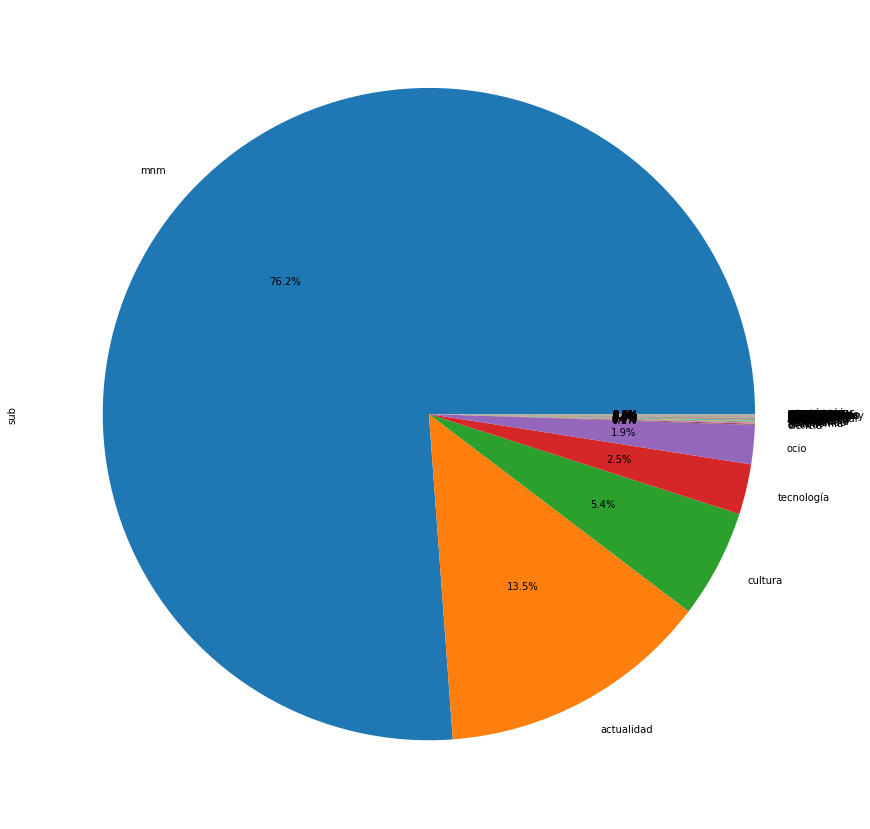

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['sub'].value_counts().plot.pie( autopct = '%1.1f%%')

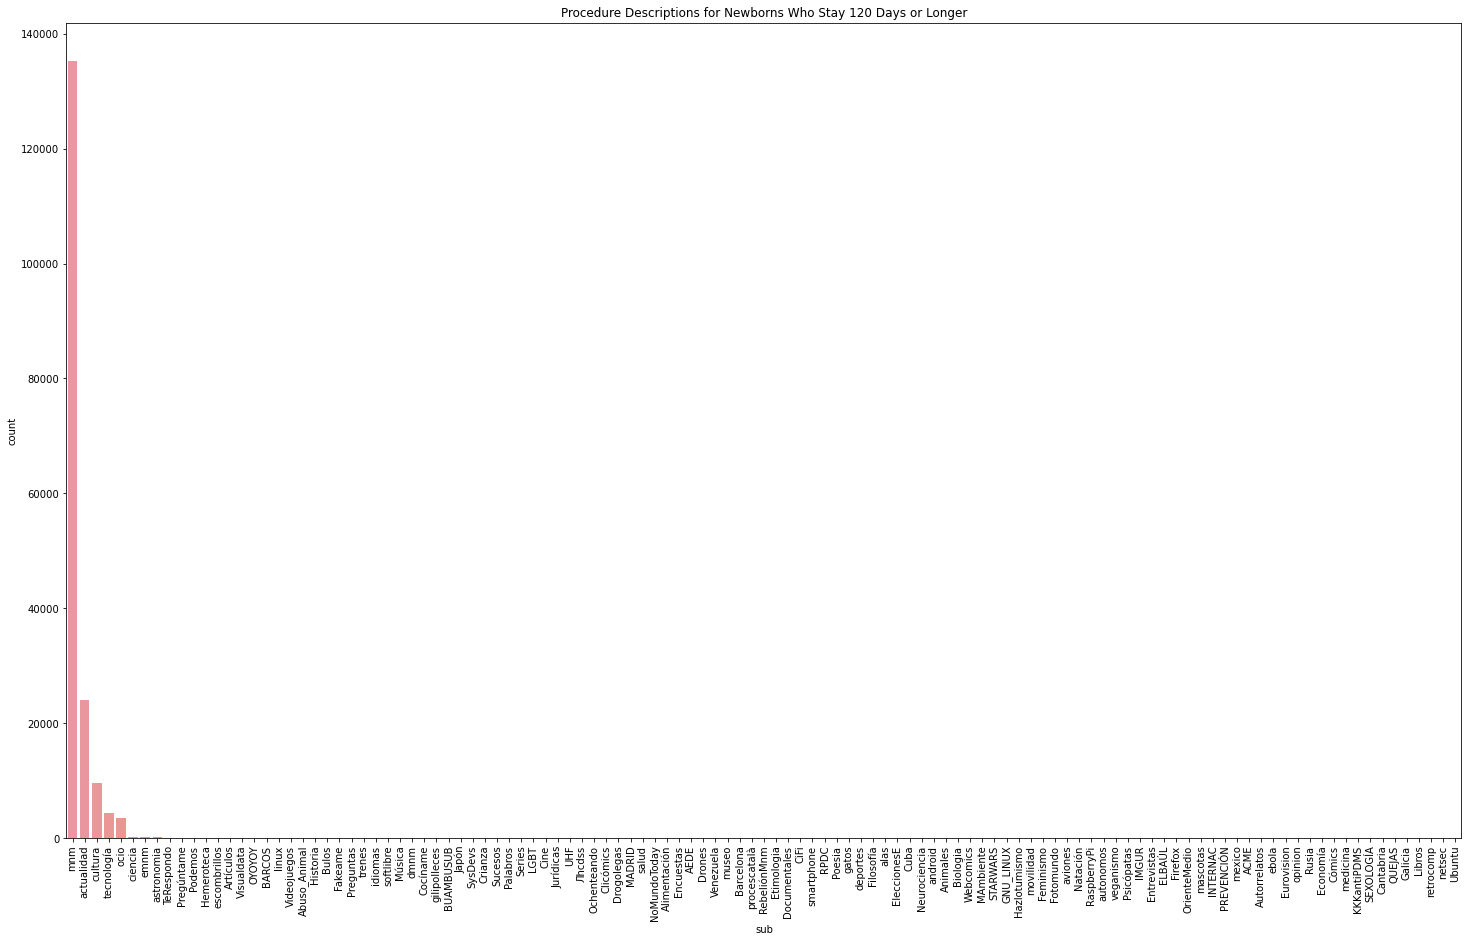

In [17]:
f, ax = plt.subplots(figsize=(25, 15))
sns.countplot(x='sub', data = df,
             order = df['sub'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Procedure Descriptions for Newborns Who Stay 120 Days or Longer')
plt.show()

Vemos que esta bastante descompensado el dataset, ya que hay un **76.2%** de noticias que estan en la categoria mnm. Mnm es una categoría que viene de la web Menéame, las cuales no representan ninguna temática en concreto. Es por esto que nos interesa eliminar esta clase de nuestros datos para poder realizar la predicción adecuadamente.

In [18]:
df_mnm = df.loc[df['sub'] == 'mnm']
df = df.loc[df['sub'] != 'mnm']

<AxesSubplot:ylabel='sub'>

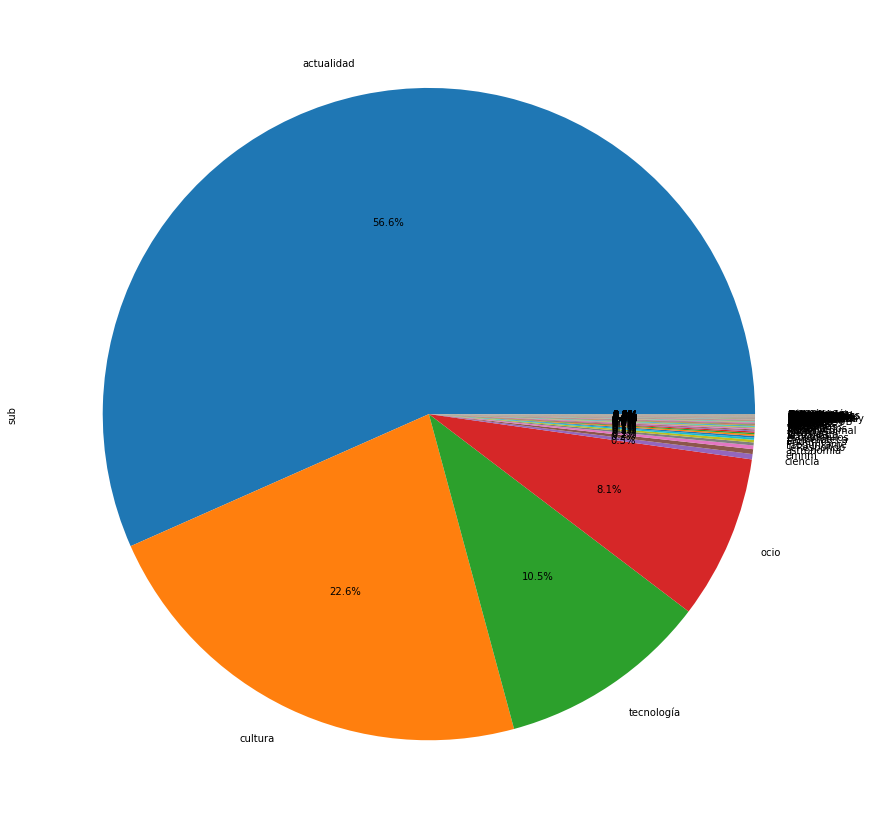

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['sub'].value_counts().plot.pie( autopct = '%1.1f%%')

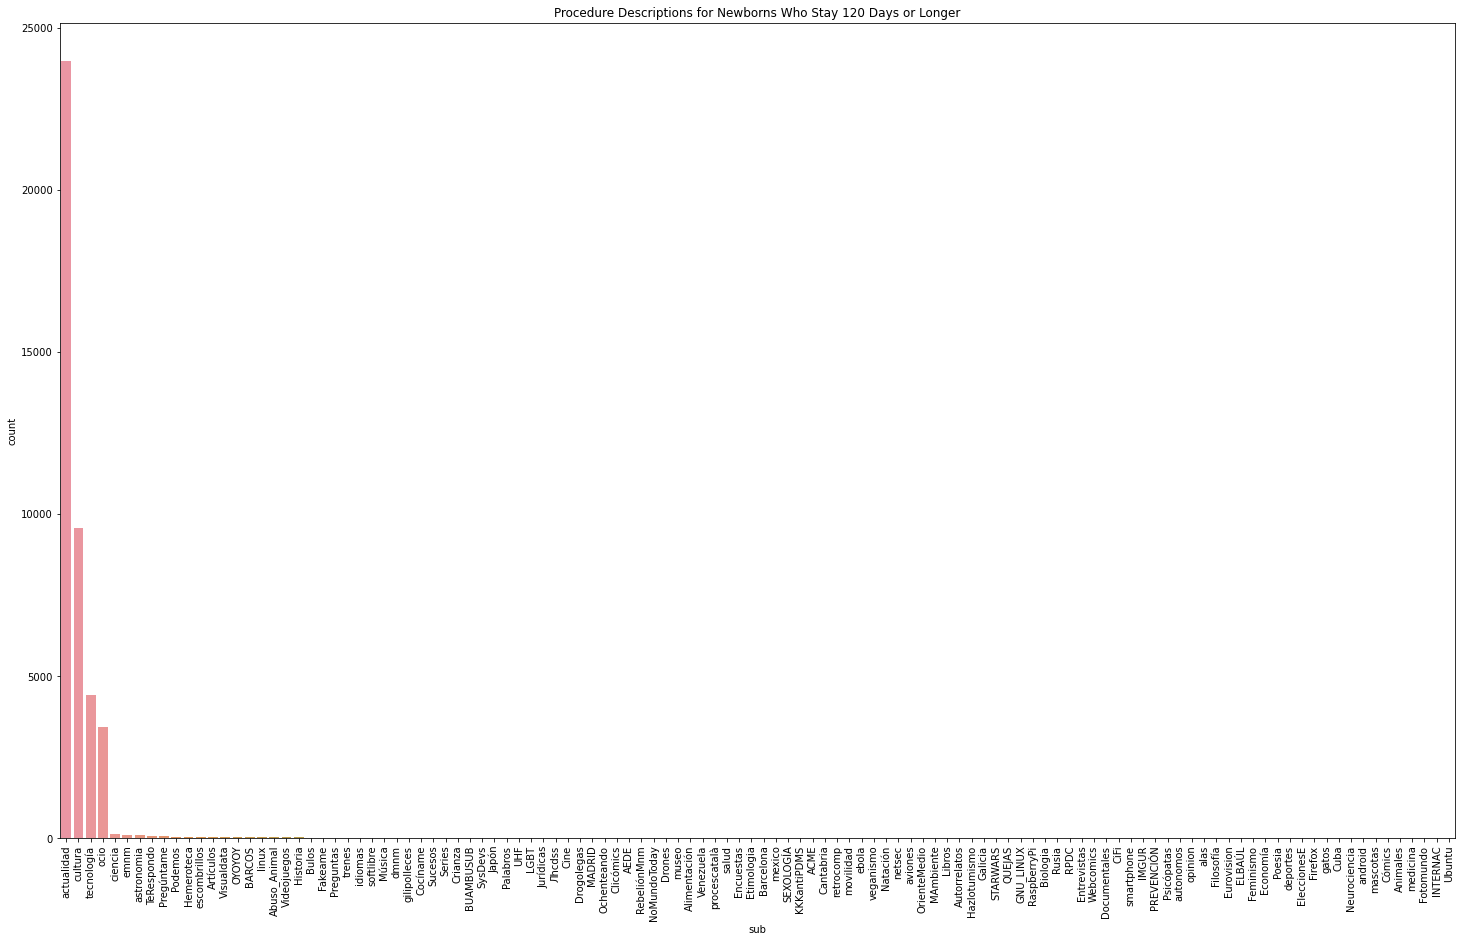

In [20]:
f, ax = plt.subplots(figsize=(25, 15))
sns.countplot(x='sub', data = df,
             order = df['sub'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Procedure Descriptions for Newborns Who Stay 120 Days or Longer')
plt.show()

Vemos que hay 4 clases relevantes en nuestros datos que representan el **98.7 %** de los mismos. Es por esto que vamos a quedarnos con estas cuatro clases: tecnología, ocio, actualidad y cultura, de esta forma, realizaremos una predicción de los datos que contengan una de estas categorías.

### 2. División de clases

In [21]:
df = df[df['sub'].isin(['tecnología','ocio','actualidad','cultura'])]
df['sub'].describe()

count          41365
unique             4
top       actualidad
freq           23959
Name: sub, dtype: object

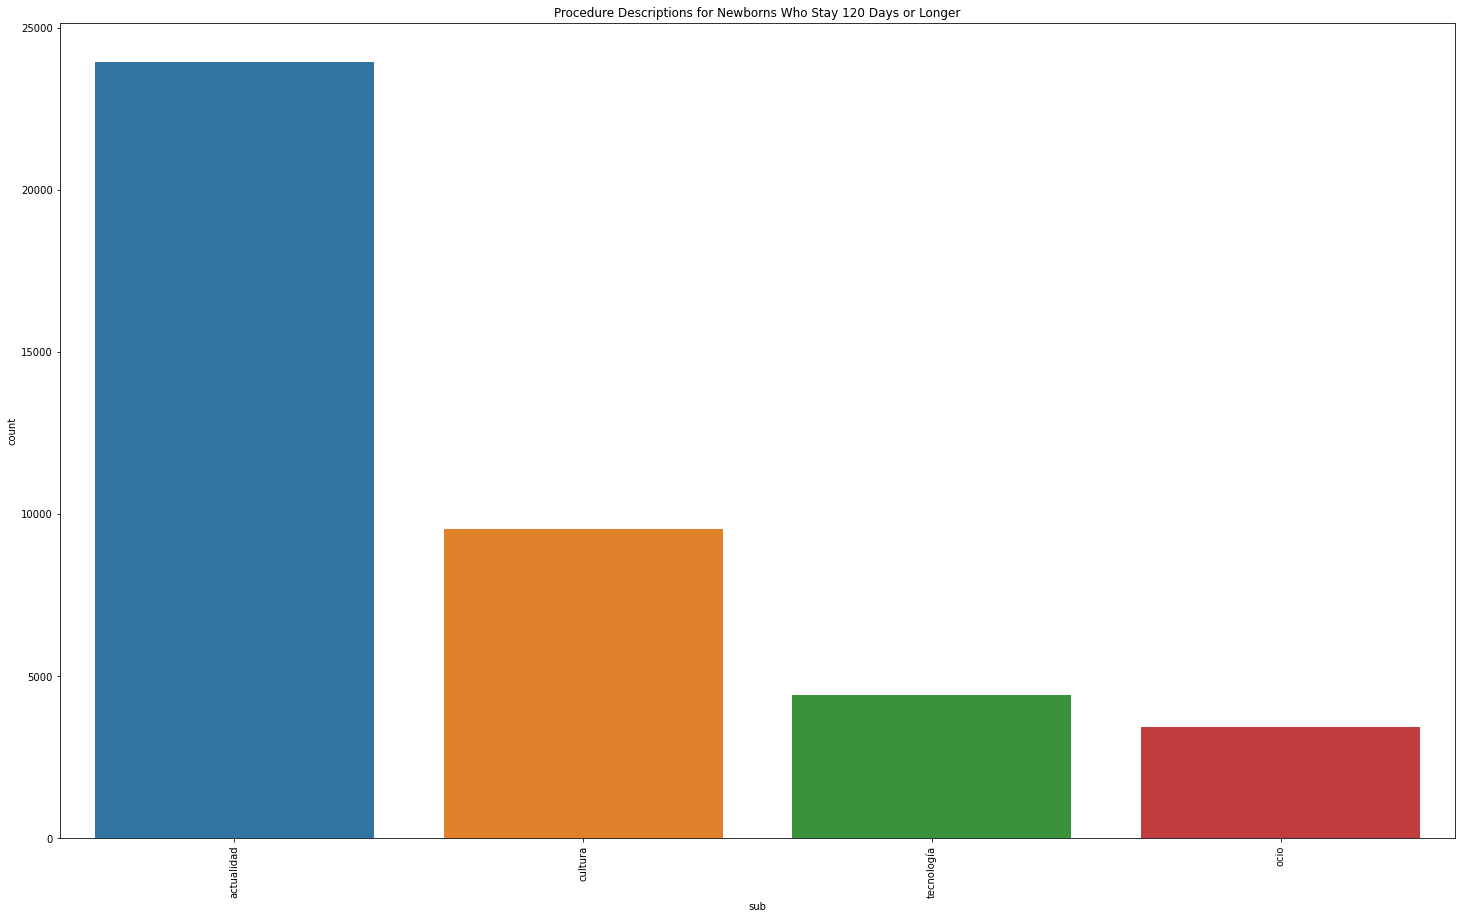

In [22]:
f, ax = plt.subplots(figsize=(25, 15))
sns.countplot(x='sub', data = df,
             order = df['sub'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Procedure Descriptions for Newborns Who Stay 120 Days or Longer')
plt.show()

<AxesSubplot:ylabel='sub'>

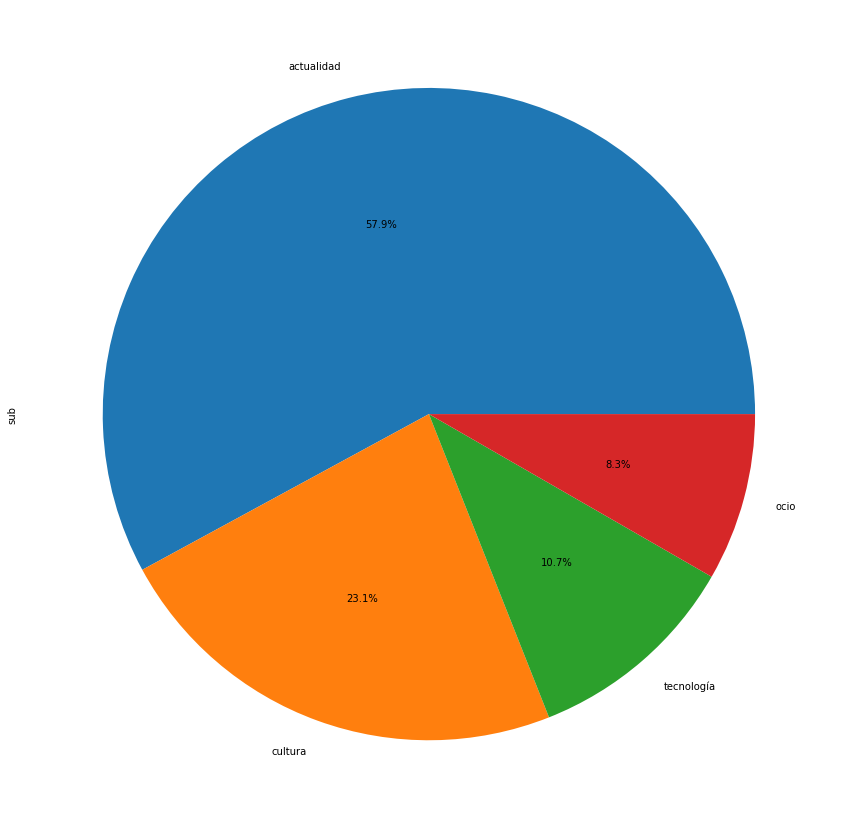

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['sub'].value_counts().plot.pie( autopct = '%1.1f%%')

Como se puede apreciar de forma más clara en estos gráficos,estan bastantes descompensadas estas clases, actualidad representa un **57.9%** de los datos, mientras que ocio lo hace solo un **8.3%**. Por eso, mas adelante, realizaremos un balanceo de las clases para ver que mejora supone esto a los modelos:

In [24]:
df = df.dropna()
X = df[['noticia','extracto']]
y = df[['sub']]

In [25]:
X.head()

,noticia,extracto
0,Ruptura inesperada de un iceberg gigante desp...,Una animación del iceberg gigante que nació de...
1,"El MIT logra hacer escáneres 3D baratos 1,000...",Los científicos ya desarrollaron una tecnologí...
2,"“Lárgame un cilindrín, fotero”","‘La gran superproducción‘ es, sin ningún géner..."
3,El Tribunal Supremo deja en prisión a Junquer...,El juez Llarena acuerda libertad previo pago d...
4,La Fiscalía pide imputar a Aguirre y Gallardó...,La Fiscalía en el caso Lezo ha solicitado impu...


In [26]:
y.describe()

,sub
count,41327
unique,4
top,actualidad
freq,23933


### 3. Normalización:

Normalizamos el texto para obtener una forma canónica del mismo y ppoder realizar modelos que tengan mayor precisión.

In [27]:
nlp=spacy.load('es_core_news_md')

#lista de stop-words que tendremos en nuestras noticias
stop_words = ['unos', 'unas', 'algún', 'alguna', 'algunos', 'algunas', 'ese', 'eso', 'así']

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens if not (tok in stop_words) and not tok.isdigit() and len(tok)>2]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [28]:
for i in tqdm(range(len(X)), desc='Normalizando texto...'):
    X.iloc[i][0] = clean_text(X.iloc[i][0])
    X.iloc[i][1] = clean_text(X.iloc[i][1])

Normalizando texto...: 100%|██████████████████████████████████████████████████| 41327/41327 [17:31:00<00:00,  1.53s/it]


In [29]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [30]:
print('-'*21,' Longitud ','-'*21)
print('X_train:',len(X_train), X_train.shape,' '*5,'X_test',len(X_test),X_test.shape)
print('y_train:',len(y_train),y_train.shape,' '*5,'y_test',len(y_test),y_test.shape)
print('-'*54)

---------------------  Longitud  ---------------------
X_train: 33061 (33061, 2)       X_test 8266 (8266, 2)
y_train: 33061 (33061, 1)       y_test 8266 (8266, 1)
------------------------------------------------------


In [31]:
print('NAs X_train:',X_train.isnull().values.any())
print('NAs X_test:',X_test.isnull().values.any())

NAs X_train: False
NAs X_test: False


In [32]:
X_train.to_csv('./data_t/X_train.csv')
X_test.to_csv('./data_t/X_test.csv')
y_train.to_csv('./data_t/y_train.csv')
y_test.to_csv('./data_t/y_test.csv')

Creamos los csv porque el proceso de normailización es bastante largo, y no queremos ejecutarlo cada vez que queramos continuar la ejecucción.

### 4. Lectura y Post-preprocesing

Leemos los csv que hemos creado anteriormente, a partir de este punto podemos volver a ejecutar el fichero sin tener que realizar la normalización.

In [11]:
X_train = pd.read_csv('data/X_train.csv',usecols=['noticia','extracto'])
X_test = pd.read_csv('data/X_test.csv',usecols=['noticia','extracto'])
y_train = pd.read_csv('data/y_train.csv',usecols=['sub'])
y_test = pd.read_csv('data/y_test.csv',usecols=['sub'])

Vemos que realizando la lectura se producen algunos valores nulos.

In [34]:
print('NAs X_train:',X_train.isnull().values.any())
print('NAs X_test:',X_test.isnull().values.any())

NAs X_train: True
NAs X_test: True


In [35]:
print('-'*21,' Longitud ','-'*21)
print('X_train:',len(X_train), X_train.shape,' '*5,'X_test',len(X_test),X_test.shape)
print('y_train:',len(y_train),y_train.shape,' '*5,'y_test',len(y_test),y_test.shape)
print('-'*54)

---------------------  Longitud  ---------------------
X_train: 33061 (33061, 2)       X_test 8266 (8266, 2)
y_train: 33061 (33061, 1)       y_test 8266 (8266, 1)
------------------------------------------------------


In [12]:
na_free = X_train.dropna()
only_na = X_train[np.invert(X_train.index.isin(na_free.index))]
X_train = na_free
y_train = y_train.drop(labels=only_na.index)
#################################################################
na_free = X_test.dropna()
only_na = X_test[np.invert(X_test.index.isin(na_free.index))]
X_test = na_free
y_test = y_test.drop(labels=only_na.index)

In [37]:
print('NAs X_train:',X_train.isnull().values.any())
print('NAs X_test:',X_test.isnull().values.any())

NAs X_train: False
NAs X_test: False


Vemos como nos deshacemos de 38 valores nulos en el train, y 13 en el test.

In [38]:
print('-'*21,' Longitud ','-'*21)
print('X_train:',len(X_train), X_train.shape,' '*5,'X_test',len(X_test),X_test.shape)
print('y_train:',len(y_train),y_train.shape,' '*5,'y_test',len(y_test),y_test.shape)
print('-'*54)

---------------------  Longitud  ---------------------
X_train: 33033 (33033, 2)       X_test 8260 (8260, 2)
y_train: 33033 (33033, 1)       y_test 8260 (8260, 1)
------------------------------------------------------


#### Creación de una nueva columna

En esa nueva columna, tendremos la parte de la noticia y la parte del extracto junta. Para ello , creamos una función:

In [13]:
def df_join(df):
    df['noticia_completa'] = df['noticia'].map(str)+ ' ' + df['extracto']
    dfnew = df['noticia_completa']

    return dfnew
    
# Estos conjuntos nos servirán al final para probar los modelos con el conjunto test:
X_train2 = df_join(X_train)
X_test2 = df_join(X_test)

In [40]:
X_train2[3]

'psoe valenciano rubalcaba obtiene peor resultado historia psoe aún había tocado fondo los resultados las elecciones europeas celebradas este domingo han dado los socialistas peor resultado historia por debajo incluso del 27 que obtuvieron las elecciones municipales efecto las declaraciones machistas del candidato conservador miguel arias cañete fuerte desgaste del partido gobierno los socialistas sólo resisten andalucía extremadura asturias'

#### División train y validación:

Vamos a dividir el conjunto en validación. Al final, lo haremos sobre el conunto test con los modelos que tengan mejores resultados.

In [14]:
Xtr,Xts,ytr,yts = train_test_split(X_train2,y_train,test_size=0.2, random_state=42)

### 5. Vectores Sparce

Vamos a realizar la extracción de características donde convertimos los documentos de texto en vectores numéricos, de esta forma, podremos entrenar nuestros modelos. Para ello, para empezar, vamos a utilizar los vectores Space Model: Bag of Words y TF-IDF

In [15]:
#Creamos los vectorizadores:
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [16]:
# Vamos a entrenar con el conjunto de train los vectorizadores:
bow_train_x = bow_vectorizer.fit_transform(Xtr)  
tfidf_train_x = tfidf_vectorizer.fit_transform(Xtr) 

# Ahora lo aplicamos sobre el conjunto test (el vector ya entrenado):
bow_test_x = bow_vectorizer.transform(Xts) 
tfidf_test_x = tfidf_vectorizer.transform(Xts)

En este apartado realizaremos distintos modelos en los que estudiaremos los resultados que nos ofrecen para la métrica f1_score. Una buena métrica para medir clases desbalanceadas, porque la accuracy nos ofrece resultados sesgados por la clase mayoritaria.

In [17]:
lista_resultados = [] #Lista para guardar los resultados del modelo
target_names = ['Actualidad','Cultura','Ocio','Tecnología']

#### 5.1. REGRESIÓN LOGÍSTICA:
En primer lugar analizaremos el modelo para la matriz bow, y posteriormente lo realizaremos con tfidf. 

f1 score: 75.74%


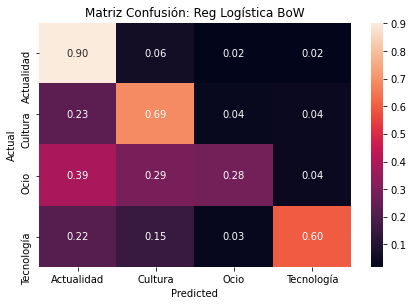

In [78]:
warnings.filterwarnings("ignore")

# Modelo con BoW:
model = LogisticRegression(solver='liblinear').fit(bow_train_x, ytr)

# Predicción
prediction = model.predict(bow_test_x)
m1_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m1_1))

# Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logística BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


Vemos como el modelo consigue predecir con gran precisión actualidad, pero nuestro problema lo tenemos con la categoria de Ocio donde el modelo falla bastante.


f1 score: 74.68%


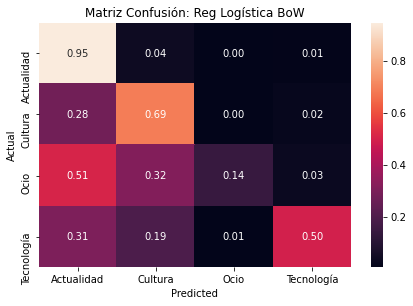

In [79]:
warnings.filterwarnings("ignore")

# Modelo con TF-IDF:
model = LogisticRegression(solver='liblinear').fit(tfidf_train_x, ytr)

# Predicción
prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m1_2))

# Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logística BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Añadimos a la lista 
lista_resultados.append(('Reg Logística',m1_1,m1_2))

#### 5.2. Multinomial NB:

f1 score: 77.27%


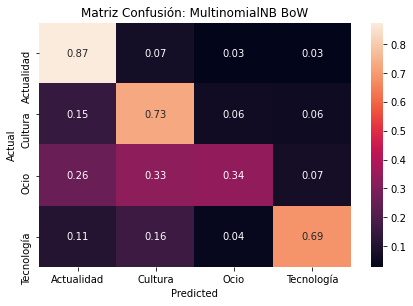

In [80]:
#Modelo:
model = MultinomialNB(alpha=0.05).fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m2_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m2_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



f1 score: 75.92%


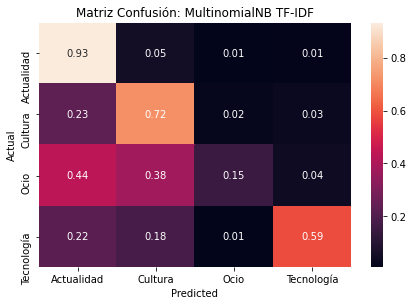

In [81]:
#Modelo
model = MultinomialNB(alpha=0.05).fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m2_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m2_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Añadimos a la lista 
lista_resultados.append(('Multinomial NB',m2_1,m2_2))

#### 5.3. SGDC Classifier

f1 score: 74.07%


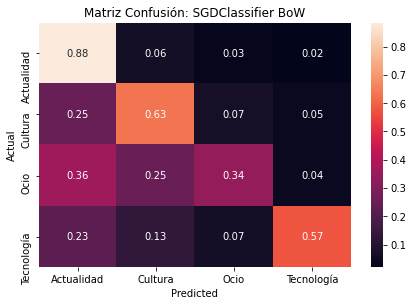

In [82]:
#Modelo
model = SGDClassifier(loss='hinge').fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m3_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDClassifier BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 75.54%


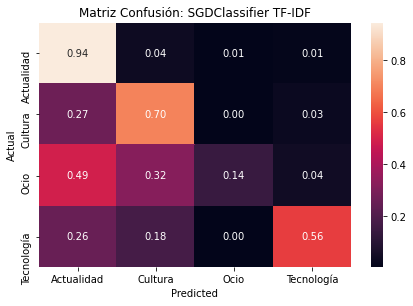

In [83]:
#Modelo
model = SGDClassifier(loss='hinge').fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m3_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDClassifier TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Añadimos a la lista
lista_resultados.append(('SGDC Classifier',m3_1,m3_2))

#### 5.4. Linear SVC

f1 score: 73.43%


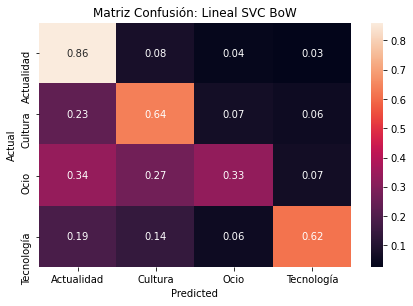

In [84]:
from sklearn.svm import LinearSVC
#Modelo
model = LinearSVC().fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m4_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Lineal SVC BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 73.43%


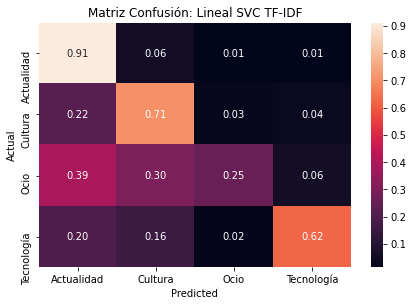

In [85]:
#Modelo
model = LinearSVC().fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m4_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Lineal SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados.append(('Linear SVC',m4_1,m4_2))

#### 5.5. Descicion Tree Classifier

Ahora, vamos a realizar la clasificación con árboles de decisión. 

f1 score: 60.39%


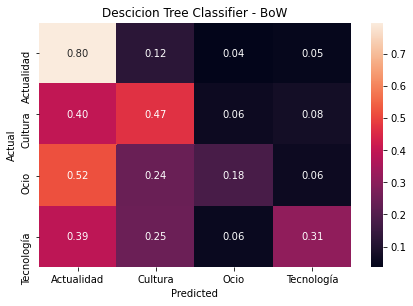

In [86]:
#Modelo
model = DecisionTreeClassifier().fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m5_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m5_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Descicion Tree Classifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 60.78%


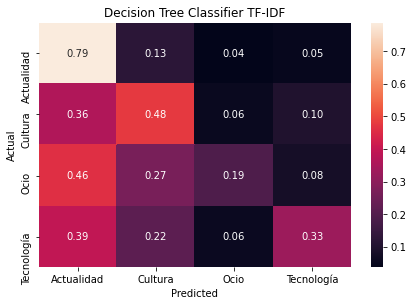

In [87]:
#Modelo
model = DecisionTreeClassifier().fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m5_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m5_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Decision Tree Classifier TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados.append(('Decision Tree Clasifier',m5_1,m5_2))

#### 5.6. Random Forest Clasifier

f1 score: 63.4%


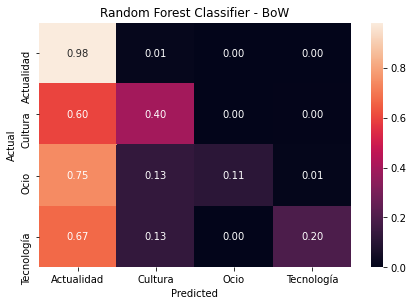

In [88]:
#Modelo
model = RandomForestClassifier().fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m6_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m6_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Classifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 63.54%


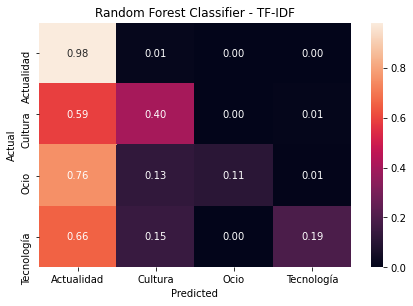

In [89]:
#Modelo
model = RandomForestClassifier().fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m6_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m6_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Classifier - TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados.append(('Random Forest Clasifier',m6_1,m6_2))

#### 5.7. Comparación de los modelos: 

In [90]:
data_modelos_1 = pd.DataFrame(lista_resultados, columns=['model', 'f1 score BoW', 'f1 score TF-IDF'])

In [91]:
data_modelos_1

,model,f1 score BoW,f1 score TF-IDF
0,Reg Logística,75.74,74.68
1,Multinomial NB,77.27,75.92
2,SGDC Classifier,74.07,75.54
3,Linear SVC,73.43,76.60
4,Decision Tree Clasifier,60.39,60.78
5,Random Forest Clasifier,63.40,63.54


- Vemos que los árboles de decisión obtienen unos resultados bastante peores que los otros modelos. Podemos observar que los modelos tienen una gran tasa de fallo en la categoría de ocio, es por ello, que tenemos que buscar la manera de intentar conseguir un mejor resultado en este aspecto. Por otra parte, vemos como el f1 score no es del todo determinante para elegir el modelo, ya que hay modelos que predicen una gran mayoría como actualidad, y consigue una gran precisión en esta parte, lo que hace que tenga un buen f1 score. Tenemos que realizar un análisis de la matriz de confusión.

### 6. Balanceo de clases

Como hemos apuntado, pensamos que los resultados podrian mejorar con un balanceo de las clases ya que, por ejemplo la clase de ocio, la cual suele fallar bastente nuestros modelos, solo representa un **8.3%** de nuestros datos, mientras que actualidad lo hace un **56.6%**. En los resultados anteriores, vemos que actualidad representa las mayor precisión en los resultados de nuestros modelos, y pensamos que se debe a que también representa un mayor número de observaciones en nuestro dataset. Es por esto, que el balanceo de clases nos puede ayudar.

Para balancear las clases hay dos formas de hacerlo:

- Submuestreo: Eliminar las muestras de las clases sobrerrepresentadas. Es más útil cuando el conjunto de datos es grande.
- Sobremuestreo: Añadir más muestras de clases infrarrepresentadas. Es más útil cuando el conjunto de datos es pequeño.

Como nuestro conjunto de datos es grande, vamos a balancear las clases utilizando sobremuestreo. Lo haremos con **SMOTE**, que es un método de sobremuestreo que crea muestras sintéticas de la clase minoritaria. Usamos el paquete **imblearn** para sobremuestrear las clases minoritarias.

También existe la opción de scikit-learn, de balancear las clases en los modelos con el parámetro class_weight= "balanced". Esto lo haremos en algunos modelos más adelante. Ahora, lo hacemos con SMOTE:

In [18]:
smote = SMOTE(random_state = 101)

X_sm_bow, y_sm_bow = smote.fit_resample(bow_train_x, ytr)
X_sm_tfidf, y_sm_tfidf = smote.fit_resample(tfidf_train_x, ytr)

print(X_sm_bow.shape, y_sm_bow.shape)

(61320, 79675) (61320, 1)


<AxesSubplot:ylabel='None'>

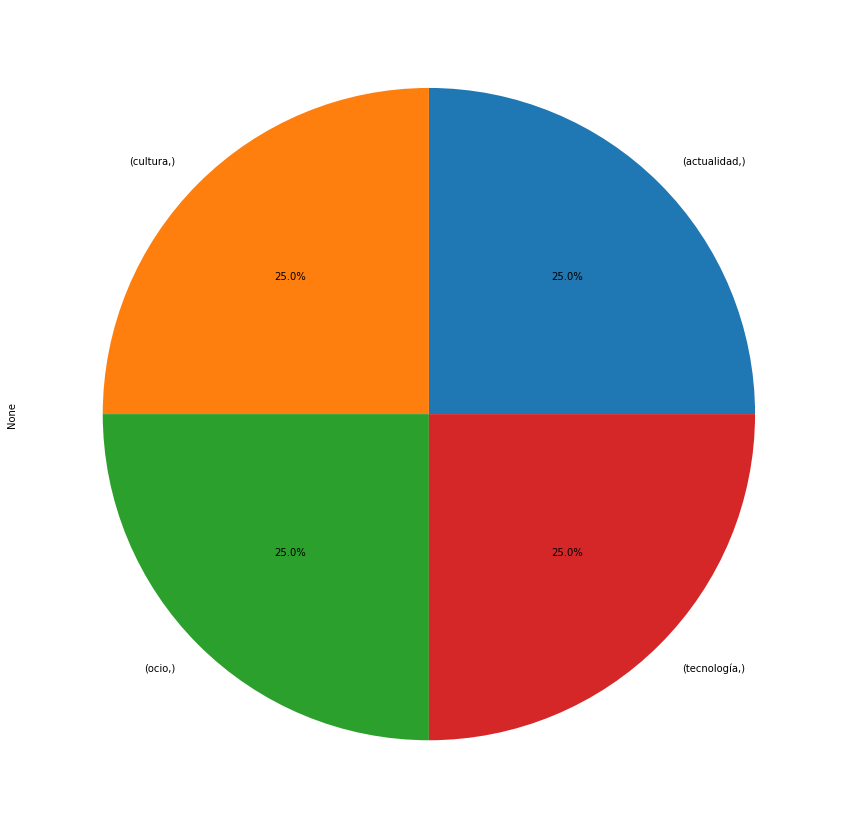

In [19]:
df_sub_bal = pd.DataFrame(data=y_sm_bow)
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df_sub_bal.value_counts().plot.pie( autopct = '%1.1f%%')

Una vez tenemos las clases balanceadas, vamos a ver los resultados de los modelos:

In [61]:
lista_resultados_sm = []

#### 6.1. REGRESIÓN LOGÍSTICA:

F1 Score : 74.63%


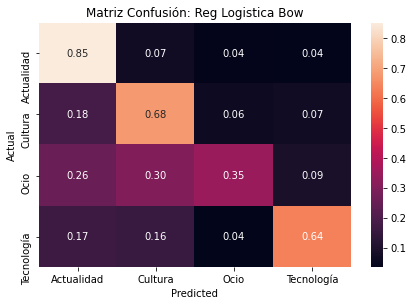

In [62]:
#Modelo
model = LogisticRegression(solver='liblinear').fit(X_sm_bow, y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m1_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logistica Bow")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

F1 Score : 77.61%


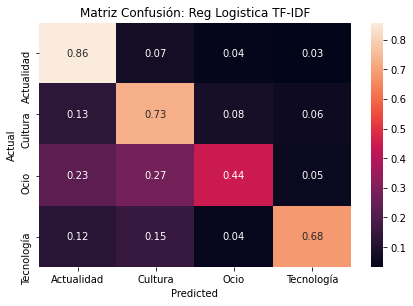

In [63]:
model = LogisticRegression().fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logistica TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Reg Logistica',m1_1,m1_2))

#### 6.2. Multinomial NB:

F1 Score : 77.59%


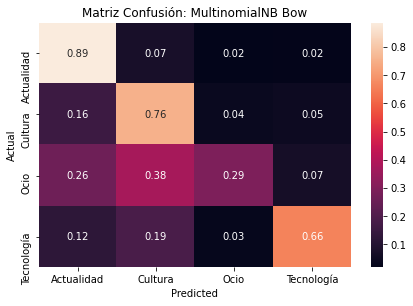

In [64]:
model = MultinomialNB(alpha=0.05).fit(X_sm_bow, y_sm_bow)

prediction = model.predict(bow_test_x)
m2_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m2_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB Bow")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


F1 Score : 77.26%


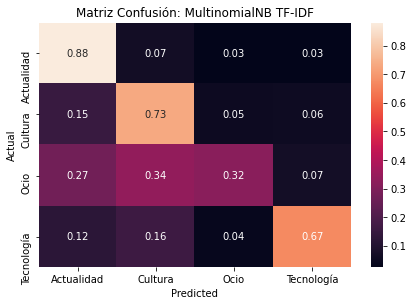

In [65]:
model = MultinomialNB(alpha=0.05).fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m2_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m2_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


lista_resultados_sm.append(('Multinomial NB',m2_1,m2_2))

#### 6.3. SGDC Classifier

f1 score: 75.54%


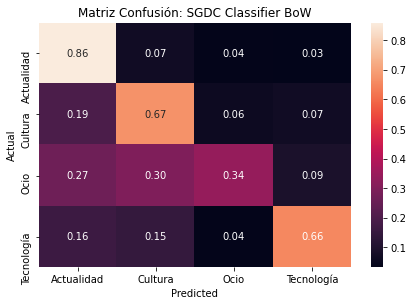

In [66]:
#Modelo
model = SGDClassifier(loss='hinge').fit(X_sm_bow,y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m3_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_2))


#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDC Classifier BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 77.68%


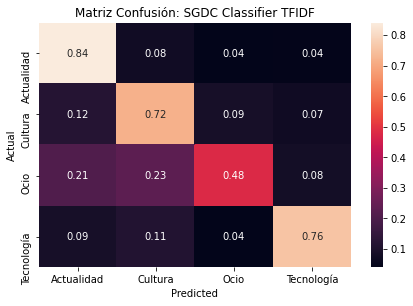

In [67]:
#Modelo
model = SGDClassifier(loss='hinge').fit(X_sm_tfidf,y_sm_tfidf)

#Predicción
prediction = model.predict(tfidf_test_x)
m3_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_2))


#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDC Classifier TFIDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
lista_resultados_sm.append(('SGDC Classifier',m3_1,m3_2))

#### 6.4 Linear SVC

F1 Score : 71.11%


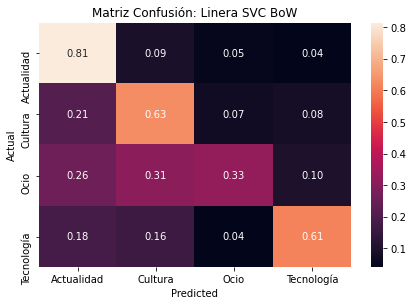

In [68]:
model = LinearSVC().fit(X_sm_bow, y_sm_bow)

prediction = model.predict(bow_test_x)
m4_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


F1 Score : 76.33%


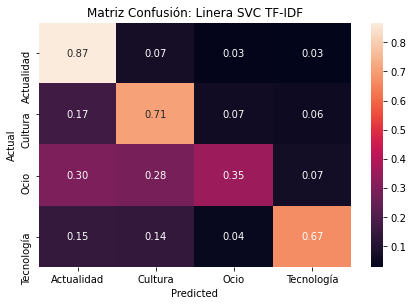

In [69]:
model = LinearSVC().fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m4_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Linear SVC',m4_1,m4_2))

#### 6.5. Descicion Tree Classifier

f1 score: 73.43%


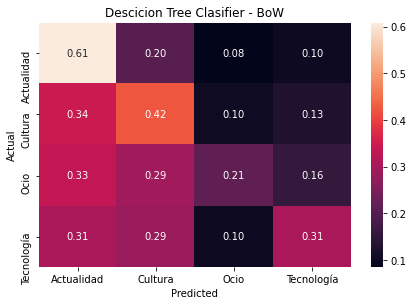

In [92]:
#Modelo
model = DecisionTreeClassifier().fit(X_sm_bow, y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m5_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Descicion Tree Clasifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 73.43%


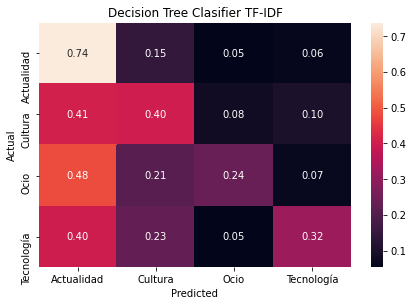

In [93]:
#Modelo
model = DecisionTreeClassifier().fit(X_sm_tfidf, y_sm_tfidf)

#Predicción
prediction = model.predict(tfidf_test_x)
m5_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Decision Tree Clasifier TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Decision Tree Clasifier',m5_1,m5_2))

#### 6.6. Random Forest Clasifier

f1 score: 73.43%


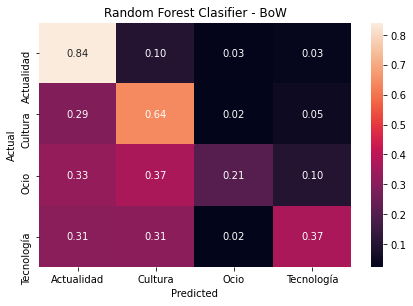

In [94]:
#Modelo
model = RandomForestClassifier().fit(X_sm_bow, y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m6_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Clasifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 73.43%


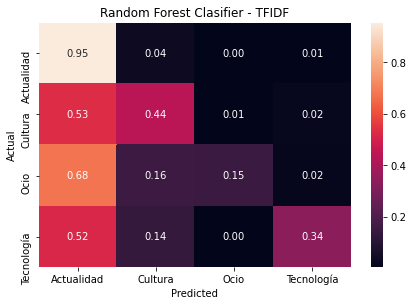

In [95]:
#Modelo
model = RandomForestClassifier().fit(X_sm_tfidf, y_sm_tfidf)

#Predicción
prediction = model.predict(tfidf_test_x)
m6_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Clasifier - TFIDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Random Forest Classifier',m6_1,m6_2))

#### 6.7. Comparación de los modelos:

In [96]:
data_modelos_sm = pd.DataFrame(lista_resultados_sm, columns=['model', 'F1 Score BoW','F1 Score TF-IDF'])

In [97]:
print('Con las clases balanceadas:')
data_modelos_sm

Con las clases balanceadas:


,model,F1 Score BoW,F1 Score TF-IDF
0,Reg Logistica,74.63,77.61
1,Multinomial NB,77.59,77.26
2,SGDC Classifier,74.91,77.68
3,Linear SVC,71.11,76.33
4,Decision Tree Clasifier,51.63,56.96
5,Random Forest Classifier,66.27,63.54


- Vemos como en esta parte, obtenemos unos mejores resultados en la categoria de ocio respecto a los modelos sin las clases balanceadas. Vemos que el SGDClassifier con la matriz TF-IDF obtiene los mejores resultados en el ocio, donde consigue predecir correctamente el 48% de los mismos; y además, realiza una predicción bastante buena de las otras clases. 


- Nos quedamos con  la Regresión Logística con la matriz TF-IDF ya que también se obtienen unos buenos resultados y presenta una mayor estabilidad respecto al SGDClassifier el cual es un modelo variable y con poca consistencia. Para realizar inferéncia nos interesa trabajar con modelos consistentes.


- Los resultados de los arboles de clasificación siguen siendo bastante malos.


- No implantamos una máquina de vector soporte (SVM) debido al gran coste computacional, es por ello que en el siguiente apartado estudiaremos el algortimo LSA para, entre otras, realizar una reducción de la dimensionalidad y poder implantar una SVM.

### 7. Modelado con Topic Moeling - LSA

En esta sección realizaremos topic modeling con dos principales finalidades.
Realizar una reducción de la dimensionalidad, con la finalidad de tratar modelos como el SVC que nos tardaban
demasiado con vectores sparse tfidf o bow.
Y por otro lado también queríamos ver como actuaban los clasificadores en una matriz sparse de tipo LSA  para
poder comparar posteriormente su resultado:

In [29]:
lsa_models = []


In [30]:
svd = TruncatedSVD(n_components=400)
lsa = make_pipeline(tfidf_vectorizer, svd, Normalizer(copy=False))
lsa_topic_vectors = lsa.fit_transform(Xtr)
lsa_test = lsa.transform(Xts)

C:\Users\guill\Anacona\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


F1 Score : 76.0%


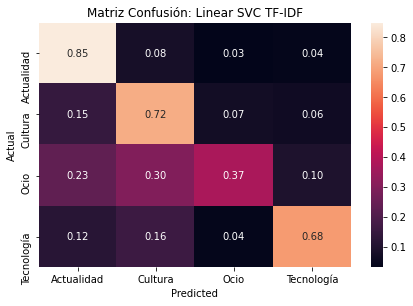

In [31]:
model = LinearSVC(class_weight='balanced').fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linear SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lsa_models.append(('LinearSVC',m1))

C:\Users\guill\Anacona\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


F1 Score : 75.86%


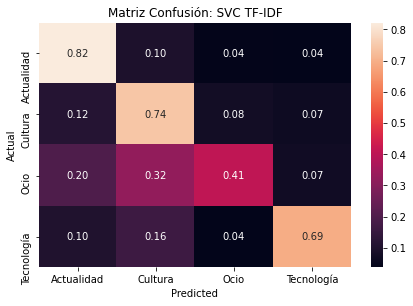

In [32]:
model = SVC(class_weight='balanced').fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lsa_models.append(('SVC',m2))

C:\Users\guill\Anacona\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\guill\Anacona\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score : 73.66%


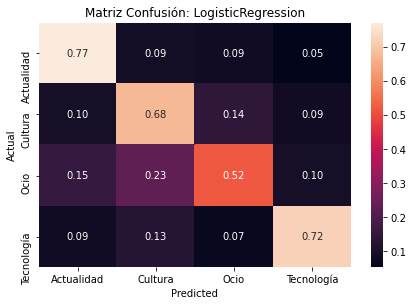

In [33]:
model = LogisticRegression(class_weight='balanced').fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m3 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m3))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: LogisticRegression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lsa_models.append(('Logistic Regression',m3))

In [34]:
data_modelos_lsa = pd.DataFrame(lsa_models, columns=['model','F1_Score'])

In [35]:
data_modelos_lsa.head()

,model,F1_Score
0,LinearSVC,76.00
1,SVC,75.86
2,Logistic Regression,73.66


En este caso el modelo con mejor f1-score es el LinearSVC, aunque el SVC ofrece muy buenos resultados también 
cuando hablamos de las clases minoritarias. Por lo tanto nos quedaremos con el LinearSVC aunque los resultados del SVC también cabe destacarlos.

### 8. Modelado con Doc2Bow

Ahora vamos a utilizar la extacción de características con vectores densos. En los modelos sparse el vector numérico no guarda relación alguna con el significado de las palabras. Los modelos densos codifican cada palabra/oración como un vector numérico con información semántica. 

In [ ]:
def etiquetado(corpus, label_type):
    """
    Para poder modelizar con el Doc2Vec de Gensim, necesito tener etiquetas para cada noticia, donde le
    asociaremos valores si el conjunto está en train o en test con una indexación posteriormente para 
    diferenciar las noticias.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
Xtr_etiqueta =etiquetado(Xtr,'train')
Xts_etiqueta = etiquetado(Xts,'test')

In [ ]:
Data_etiqueta = Xtr_etiqueta + Xts_etiqueta

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in Data_etiqueta])

for epoch in range(30):
    model_dbow.train(sklearn.utils.shuffle([x for x in Data_etiqueta]), total_examples=len(Data_etiqueta), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Con esta función obtenemos los vectores para posteriormente poder modelizar con ellos
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(Xtr), 300, 'train')
test_vectors_dbow = get_vectors(model_dbow, len(Xts), 300, 'test')


In [ ]:
lista_modelos_doc2bow= []

In [ ]:
mdc = LogisticRegression(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr,)
prediction = mdc.predict(test_vectors_dbow)
m1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m1,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: LogisticRegression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
lista_modelos_doc2bow.append(('Logistic Regresion',m1))

In [ ]:
mdc = LinearSVC(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr)
prediction = mdc.predict(test_vectors_dbow)
m2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m2,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: LinearSVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')
lista_modelos_doc2bow.append(('LinearSVC',m2))

In [ ]:
mdc = SVC(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr)
prediction = mdc.predict(test_vectors_dbow)
m3 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m3,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')
lista_modelos_doc2bow.append(('SVC',m3))

In [ ]:
mdc = SGDClassifier(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr,)
prediction = mdc.predict(test_vectors_dbow)
m4 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m4,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDClassifier")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
lista_modelos_doc2bow.append(('SGDClassifier',m4))

In [ ]:
train_y = ytr.to_numpy()

In [ ]:
data_modelos_doc2bow = pd.DataFrame(lista_modelos_doc2bow, columns=['model','F1_Score'])

In [ ]:
data_modelos_doc2bow

- Notamos que con los vectores densos de doc2bow nuestros modelos mejoran sustancialmente. Vemos que, debido a la reducción LSA antrior, podemos realizar un SVC ya que se reduce la carga computacional. 


- El SVC vemos que es bastante buen modelo, uno de los mejores. Realiza una buena predicció de la clase ocio, manteniendo una buena precisión en las otras clases.


### 9. Modelado con Keras:

En este nuevo modelo se van a utilizar las redes convolucionales para intentar encontrar una solución óptima al problema.

En concreto, sin tener en cuenta el coste computacional, la mejor opción es realizar una convolución para obtener el modelo. Sin embargo, debido al elevado coste computacional que requiere realizar una convolución, el procedimiento que se va a realizar es la definición de un perceptrón multicapa enfocado a resolver el problema de clasificación.

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
import tensorflow as tf

warnings.filterwarnings("ignore")

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(Xtr) # only fit on train

x_train_k = tokenize.texts_to_matrix(Xtr)
x_test_k = tokenize.texts_to_matrix(Xts)

encoder = LabelEncoder()
encoder.fit(ytr)
y_train_k = encoder.transform(ytr)
y_test_k = encoder.transform(yts)

num_classes = np.max(y_train_k) + 1
y_train_k = tf.keras.utils.to_categorical(y_train_k, num_classes)
y_test_k = tf.keras.utils.to_categorical(y_test_k, num_classes)


In [ ]:
warnings.filterwarnings("ignore")

from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(ytr['sub']),
                                             ytr['sub']))

weights={}
for index, weight in enumerate(class_weights) :
      weights[index]=weight

Definimos un perceptrón multicapa añadiendo una capa de neuronas oculta.

In [ ]:

model = Sequential()
batch_size = 32
epochs = 5

model.add(Dense(32, input_shape=(max_words,)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(32, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(32, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(16, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(8, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_m])

In [ ]:
history = model.fit(x_train_k, y_train_k,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    class_weight = weights)

In [ ]:
warnings.filterwarnings("ignore")
prediction = model.predict_classes(x_test_k)

In [ ]:
prediction1 = np.where(prediction==0, 'Actualidad', prediction) 
prediction2 = np.where(prediction==1, 'Cultura', prediction1) 
prediction3 = np.where(prediction==2, 'Ocio', prediction2) 
prediction_final = np.where(prediction==3, 'Tecnología', prediction3) 

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction_final)
cm = cm[4:8,0:4]
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Keras")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

Los resultados obtenidos utilizando un perceptrón multicapa no son buenos, no se consigue un buen f1_score, pero si que se obtiene una buena solución al problema de la clasificación de la categoría de Ocio. 

### 10. Mejora del los modelos:

Con los modelos que consideramos los que mejor funcionan, vamos a incluir parametros para mejorar su presición:

#### 10.1. Logistic Regresión con TFIDF - Clases balanceadas

Vamos a parametrizar el modelo para mejorar los resultados. Recordamos que el f1_score obtenido anteriormente en este modelo es de **77.61%**. 

In [ ]:
model = LogisticRegression(solver = 'newton-cg',multi_class='ovr',l1_ratio=0.5,C=1.5, random_state=1).fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_2))

# Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logística BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#### 10.2. Linear SVC - LSA

Recordaoms que anteriormente, el f1_score era de **76.12%**.

In [ ]:
model = LinearSVC(class_weight='balanced',loss = 'squared_hinge',multi_class='ovr',random_state=1).fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m4_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#### 10.3. SVC - Vector denso Doc2Bow

Vamos a intentar mejorar el modelo SVC con el vector denso. Recordamos que el f1 score anterior es **76.43 %**.

In [ ]:
mdc = SVC(class_weight='balanced',kernel = 'poly',decision_function_shape='ovr')

mdc = mdc.fit(train_vectors_dbow, ytr)
prediction = mdc.predict(test_vectors_dbow)
m3 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m3,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')


### 11. Modelos al conjunto test

Con los dos modelos anteriores, que son los que mejores resultados tienen sobre el conjunto de validación, ahora vamos a ver que resultados tienen sobre el conjunto test. Esto lo hemos realizado con la finalidad de probar el modelo con unos datos totalmente desconocidos; y asi el modelo prueba con datos totalmente nuevos.

Es verdad que, en este caso, es un poco irrelevante este paso, pero puede ayudarnos a ofrecernos una estimación de como actuarian estos modelos con unas nuevas noticias.

Repetimos el proceso anterior pero con los conjuntos de test:

#### 11.1. Regresión Logística con TFIDF - Clases balanceadas

In [ ]:
#Creamos los vectorizadores:
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
# Vamos a entrenar con el conjunto de train los vectorizadores:
bow_train_x = bow_vectorizer.fit_transform(X_train2)  
tfidf_train_x = tfidf_vectorizer.fit_transform(X_train2) 

# Ahora lo aplicamos sobre el conjunto test (el vector ya entrenado):
bow_test_x = bow_vectorizer.transform(X_test2) 
tfidf_test_x = tfidf_vectorizer.transform(X_test2)

In [ ]:
smote = SMOTE(random_state = 101)

X_sm_bow, y_sm_bow = smote.fit_resample(bow_train_x, y_train)
X_sm_tfidf, y_sm_tfidf = smote.fit_resample(tfidf_train_x, y_train)

In [ ]:
model = LogisticRegression(solver = 'newton-cg',multi_class='ovr',l1_ratio=0.5,C=1.5, random_state=1).fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(y_test, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_2))

#Matriz de connfusión:
cm = confusion_matrix(y_test, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logistica TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#### 11.2. Linear SVC - LSA

In [ ]:
svd = TruncatedSVD(n_components=400)
lsa = make_pipeline(tfidf_vectorizer, svd, Normalizer(copy=False))
lsa_topic_vectors = lsa.fit_transform(X_train2)
lsa_test = lsa.transform(X_test2)

In [ ]:
model = LinearSVC(class_weight='balanced',loss = 'squared_hinge',multi_class='ovr',random_state=1).fit(lsa_topic_vectors, y_train)

prediction = model.predict(lsa_test)
m4_2 = round(f1_score(y_test, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_2))

#Matriz de connfusión:
cm = confusion_matrix(y_test, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#### 11.3. SVC - Vector denso Doc2Bow

In [ ]:
Xtrain_etiqueta = etiquetado(X_train2,'train')
Xtests_etiqueta = etiquetado(X_test2,'test')

In [ ]:
Data_etiqueta = Xtrain_etiqueta + Xtests_etiqueta

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in Data_etiqueta])

for epoch in range(30):
    model_dbow.train(sklearn.utils.shuffle([x for x in Data_etiqueta]), total_examples=len(Data_etiqueta), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train2), 300, 'train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test2), 300, 'test')

In [ ]:
mdc = SVC(class_weight='balanced',kernel = 'poly',decision_function_shape='ovr')

mdc = mdc.fit(train_vectors_dbow, y_train)
prediction = mdc.predict(test_vectors_dbow)
m3 = round(f1_score(y_test, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m3,'%')

#Matriz de connfusión:
cm = confusion_matrix(y_test, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')


### 12. Conclusión

Como conclusión, nos gustaría destacar varios **puntos importantes** que hemos ido encontrando a lo lago de este proyecto:


- En primer lugar, los **modelos tienen bastantes dificultades con la predicción de la clase Ocio**, como se puede ver a lo largo del trabajo. Esta clase suele confundirse con las otras clases, debido a que es la clase de la que menos muestras tenemos. También hay que decir que ocio, con cultura y actualidad tiene sentido que puedan confundirse. Añadir que las noticias de nuestro dataset no contienen una gran cantidad de texto. Ninguno consigue tener una predicción buena en esta clase sin que esto suponga una reducción de presición en las otras clases. 


- Cabe destacar la **mejora que ha supuesto el balanceo de clases**. Hemos notado como los clasificadores han mejorado notablemente su predicción con los vectores sparse cuando las clases han estado balanceadas. El balanceo de las clases, el cual también hacemos con el modelo anterior con la opción de sklearn en el modelo. Es comprensible esta mejora, ya que como hemos comentado, actualidad presentaba una mayoría bastante aplastante respecto a las otras clases.


- Observamos como el **SGDClasifier funciona bien, pero vamos a rechazarlo siempre ya que no es un modelo estable**. Presenta unas grandes variaciones y es por ello que no nos interesa demasiado.


- Destacar los **modelos que han funcionado de mejorson: Logistic Regresión, SVC y LinearSVC**. Vemos como el Keras y, sobretodo, los árboles de clasificacción, no funcionan con este problema y obtienen unos resultados bastante malos.


- La aplicación de vectores densos con **Doc2bow a los modelos presentan una mejora en la predicción de la clase Ocio** respecto a las otras formas de vectorizar la infomación. 


Finalmente, **elegiriamos el modelo de Regresión Logística con la matriz TF-IDF** debido a que es la que mejor f1 score tiene entre los que hemos considerado los mejores modelos. De todas formas, los otros también funcionan bastante bien ya que tienen una mayor precisión en la clase ocio. Como todos funcionan correctamente, elegimos el mejor f1 score.